## SIMPLE FBR/PFR MODEL OF HT-WGS

Package info:
* DifferenitalEquations.jl 
* Plots
* DataFrames

to get packages: in the Julia RPL type ```]``` then ``` add <PackageName>```


In [2]:
using DifferentialEquations
using Plots
using DataFrames

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


### rate model basis:
_Boon et al (2014)_ : WGS Kinetics over FeCr-based Catalyst: Effect of Hydrogen Sulphide

A simple rate model for the reaction for HT-WGS using a 80-90 wt.% Fe2O3, 8-13% Cr2O3 and 1-2% CuO catalyst at 375 to 475C, considering effect of H2S:

$$ r = 3.2 \times 10^{-6} \mathrm{exp}( -\frac{112 \times 10^{3}}{R})(T^{-1}-678^{-1})P_{CO}^{0.84}P_{H2O}^{1.17}P_{CO2}^{-0.36}P_{H2}^{0.09}P_{H2S}^{-0.3}(1-\beta)$$

where 

$$ \beta = P_{CO2}P_{H2}/K_{eq}P_{CO}P_{H2O} $$

### eq constant basis:
_Twigg (1989)_ : Cross Ref from Review by Smith et al p.12:

$$ Z = \frac{1000}{T} - 1 $$

$$ K_{eq} = \mathrm{exp}(Z(Z(0.63508-0.29353Z)+4.1778)+0.31688) $$


### assumptions:
* no MT
* ideal gas
* isothermal

### reactor params:
randomly selecting reactor parameters that sound reasonable and taking composition of BF gas as given in the Techno-Economic Analysis + usual H2S content:

In [216]:
# initial BF gas composition
v0 = [3.59; 21.86; 22.10; (48.25-0.0012); 4.2; 0.0012]/100; # vol%,  h2, co, co2, n2, h2o,; h2s

# operating params
T  = 450 + 273;     # K
R  = 8.3145;
P  = 5 * 101325;    # Pa
ρ_cat = 500         # kg/m³

500

### IC setup:

get the flow velocity, assuming 1m² crosssectional, free flow area:

In [242]:
ṁ_BFG = 300   # kg/s

# assume BOF Density ~ Air ~ 2:
V̇ = 0.3       # m³/s
v = 0.3       # m/s

0.3

switch vol% to moleflow via ideal gas and calculate K_eq:

In [243]:
u0 = (v0 * V̇) * P / (R*T);

Z  = (1000/T) - 1;
K  = exp(Z*(Z*(0.63508-0.29353*Z)+4.1778)+0.31688);


add second stream carrying enough steam for reaction to go to completion:

In [244]:
ṅ_H2Oadd = u0[2] - u0[5];

u0[5] = u0[5] + ṅ_H2Oadd;


### ODE system:

solve the ODE system:

$$ \frac{\mathrm{d}}{\mathrm{d}V}\dot n_i = m_{cat}r_i $$

in length: 

$$ \frac{\mathrm{d}}{\mathrm{d}x}\dot n_i = u_{sg}\rho_{cat}r'_i $$

which is:

In [246]:
function rxn(du,u, p, t)
    
    # calculate partial pressures
    # kPa
    pi = P * u ./ sum(u) / 1000   
    
    # calculate rate 
    # mol/sec kg_c
    r = p[1] * exp(-( 112 * 1000) / R * ( 1/T - 1/678) ) * 
        pi[2]^0.84 * pi[5]^1.17 * pi[3]^-0.36 * pi[1]^0.09 * pi[6]^-0.3 *
        (1-( (pi[3]*pi[1]) / (K*pi[2]*pi[5]) ) )
    
    # calculate du
    # mol/m
    du[1] =  p[3] * p[2] *  r    # +H2
    du[2] =  p[3] * p[2] * -r    # -CO
    du[3] =  p[3] * p[2] *  r    # +CO2
    du[4] =  0
    du[5] =  p[3] * p[2] * -r    # -H2O
    du[6] =  0
    
end

# params
p = [3.2*10^-6; ρ_cat; 1/v]  # k, rho_cat, 1/u

# spacespan
tspan = (0.0,10.0)

# solve
prob = ODEProblem(rxn,u0,tspan,p);
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8);


### results:

plot CO conversion and mole fraction:

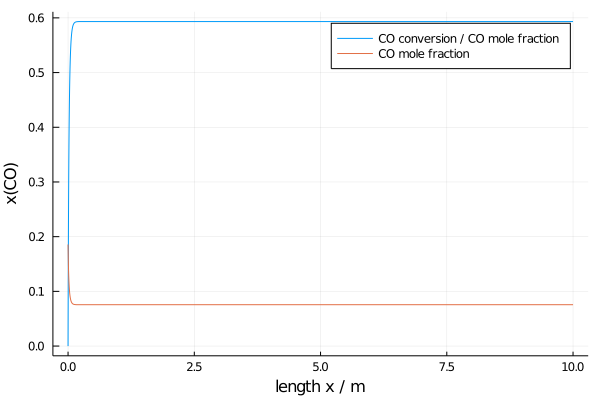

In [247]:
# extract co conversion
co = sol[2, :]
co_conv = 1 .- (co./co[1])
co_conc = co./sum(u0)


# plot CO
plot(sol.t, co_conv,
     label = "CO conversion / CO mole fraction",
     axis  = "length x / m",
     yaxis = "x(CO)")
plot!(sol.t, co_conc,
     label = "CO mole fraction")

plot other concentration profiles:

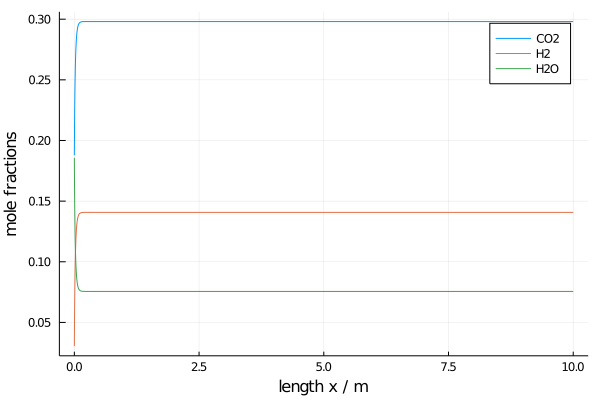

In [248]:
# plot other
co2 = sol[3, :] ./ sum(u0)
h2  = sol[1, :] ./ sum(u0)
h2o = sol[5, :] ./ sum(u0)

plot(sol.t, [co2, h2, h2o],
     labels = ["CO2" "H2" "H2O" "CO"],
     axis  = "length x / m",
     yaxis = "mole fractions")